# Preprocessing Step

In [ ]:
import pandas as pd
import numpy as np

In [2]:
data_path_small = "./data/news_wkta_100k.csv.zip"
data_path_smaller = "./data/news_wkta_50k.csv.zip"
data_path_tiny = "./data/news_wkta_25k.csv.zip"

In [3]:
data_small = pd.read_csv(data_path_small, encoding="utf-8", quotechar='"', engine="c", error_bad_lines=False, warn_bad_lines=True)

In [4]:
data_smaller = pd.read_csv(data_path_smaller, encoding="utf-8", quotechar='"', engine="c", error_bad_lines=False, warn_bad_lines=True)

In [5]:
data_tiny = pd.read_csv(data_path_tiny, encoding="utf-8", quotechar='"', engine="c", error_bad_lines=False, warn_bad_lines=True)

In [6]:
def clean_join_text_cols(df, col_a, col_b, out_col):
    def clean_text_col(d):
        return " \n ".join(d.splitlines())
    df[out_col] = df[[col_a, col_b]].apply(lambda r: clean_text_col(r[col_a]) + " <ENDTITLE> \n " + clean_text_col(r[col_b]), axis=1)

In [7]:
clean_join_text_cols(data_small, "title", "content", "title_content")

In [8]:
data_small["content_length"] = data_small.content.apply(lambda d: len(d.split()))
data_small["title_length"] = data_small.title.apply(lambda d: len(d.split()))

In [9]:
clean_join_text_cols(data_smaller, "title", "content", "title_content")

In [10]:
data_smaller["content_length"] = data_smaller.content.apply(lambda d: len(d.split()))
data_smaller["title_length"] = data_smaller.title.apply(lambda d: len(d.split()))

In [11]:
clean_join_text_cols(data_tiny, "title", "content", "title_content")

In [12]:
data_tiny["content_length"] = data_tiny.content.apply(lambda d: len(d.split()))
data_tiny["title_length"] = data_tiny.title.apply(lambda d: len(d.split()))

In [13]:
data_tiny.type.value_counts()

political     22474
bias           1309
conspiracy      561
junksci         216
clickbait       170
unknown         137
satire           79
unreliable       51
fake              3
Name: type, dtype: int64

In [16]:
data_tiny.fake.value_counts()

0    23920
1     1080
Name: fake, dtype: int64

# KEYWORD AS EVENT CLASS

In [14]:
def get_keyword_col_names(df, prefix="has_mk_"):
    return [col for col in df.columns if "has_mk_" in col]

In [15]:
keyword_cols = get_keyword_col_names(data_tiny)

In [17]:
# Loading metadata counts
import ast
from collections import Counter
counts_keywords, counts_tags, counts_authors = None, None, None
with open("./data/metadata_counts.txt", "r") as f:
    c = f.read().split("Counter(")
    counts_keywords = Counter(ast.literal_eval(c[1][:-2]))
    counts_tags = Counter(ast.literal_eval(c[2][:-2]))
    counts_authors = Counter(ast.literal_eval(c[3][:-2]))

In [18]:
prefix = "has_mk_"
most_common_keywords = [prefix + k[0] for k in counts_keywords.most_common(25)]

In [19]:
def get_most_common_keyword_for_news_item(item):
    for col in most_common_keywords:
        if item[col] == 1:
            return col[len(prefix):]
    return 0

In [20]:
data_small["keyword"] = data_small.apply(get_most_common_keyword_for_news_item, axis=1)
data_small["keyword"].value_counts()

climate change     35367
business           22544
energy             16581
health              8210
politics            4342
biodiversity        3772
russia              3164
donald trump        1745
united states       1338
china                776
barack obama         737
hillary clinton      488
food                 265
science              241
economics            135
cuba                  99
ebola                 61
transportation        53
fracking              43
coal                  24
tips                   8
pipelines              4
cop21                  3
Name: keyword, dtype: int64

In [21]:
data_smaller["keyword"] = data_smaller.apply(get_most_common_keyword_for_news_item, axis=1)
data_smaller["keyword"].value_counts()

climate change     17678
business           11140
energy              8386
health              4113
politics            2194
biodiversity        1938
russia              1562
donald trump         858
united states        689
china                380
barack obama         372
hillary clinton      235
science              120
food                 119
economics             68
cuba                  48
transportation        27
ebola                 25
fracking              21
coal                  18
tips                   7
pipelines              1
cop21                  1
Name: keyword, dtype: int64

In [22]:
data_tiny["keyword"] = data_tiny.apply(get_most_common_keyword_for_news_item, axis=1)
data_tiny["keyword"].value_counts()

climate change     8829
business           5545
energy             4204
health             2098
politics           1111
biodiversity        987
russia              774
donald trump        391
united states       340
barack obama        194
china               188
hillary clinton     113
food                 59
science              55
economics            39
cuba                 23
ebola                13
transportation       12
fracking             11
coal                  9
tips                  4
pipelines             1
Name: keyword, dtype: int64

In [32]:
data_small.to_csv("./data/news_full_100k.csv", index=False)

In [31]:
data_smaller.to_csv("./data/news_full_50k.csv", index=False)

In [30]:
data_tiny.to_csv("./data/news_full_25k.csv", index=False)

# COMPUTATIONS FOR TEXT EMBEDDING

In [24]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [26]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [27]:
token_lens = []
for txt in data_small.title_content:
    token_lens.append(len(tokenizer.encode(txt, max_length=1024)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/Users/pablokvitca/anaconda3/envs/nn-project/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


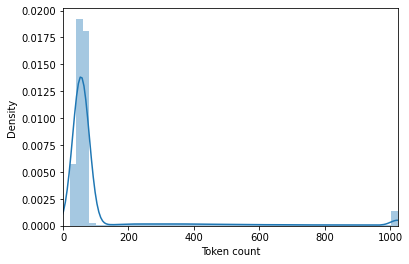

In [28]:
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');

In [29]:
MAX_LENGTH = 128